<h1>CNN Token-Level Language Model</h1>

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [23]:
# model classes

class Linear:
		
		def __init__(self, fan_in, fan_out, bias=True):
				self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming initialization
				self.bias = torch.zeros(fan_out) if bias else None
				
		def __call__(self, x):
				self.out = x @ self.weight
				if self.bias is not None:
						self.out += self.bias
				return self.out
		
		def parameters(self):
				return [self.weight] + ([] if self.bias is None else [self.bias])
		
		
class BatchNorm1d:
		
		def __init__(self, dim, eps=1e-5, momentum=0.1):
				self.eps = eps
				self.momentum = momentum
				self.training = True
				# parameters (trained with backprop)
				self.gamma = torch.ones(dim)
				self.beta = torch.zeros(dim)
				# buffers (trained with updates)
				self.running_mean = torch.zeros(dim)
				self.running_var = torch.ones(dim)
				
		def __call__(self, x):
				# calculate forward pass
				if self.training:
						x_mean = x.mean(0, keepdim=True)
						x_var = x.var(0, keepdim=True)
				else:
						x_mean = self.running_mean
						x_var = self.running_var
				
				x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
				self.out = self.gamma * x_hat + self.beta
				
				if self.training:
						with torch.no_grad():
								self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
								self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
				
				return self.out
								
		def parameters(self):
				return [self.gamma, self.beta]
  
class Embedding:
	def __init__(self, num_embeddings, embedding_dim):
		self.weight = torch.randn((num_embeddings, embedding_dim))
  
	def __call__(self, IX):
		self.out = self.weight[IX]
		return self.out

	def parameters(self):
		return [self.weight]

class Flatten:

	def __call__(self, x):
		self.out = x.view(x.shape[0], -1)
		return self.out
	def parameters(self):
		return []
  						
class Tanh:
		def __call__(self, x):
				self.out = torch.tanh(x)
				return self.out
		def parameters(self):
				return []
  
class Sequential:
	
	def __init__(self, layers):
		self.layers = layers
	
	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		self.out = x
		return self.out

	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]

In [14]:
torch.manual_seed(42);

In [15]:
# read words
words = open('../data/names.txt').read().splitlines()
block_size = 3

In [16]:
# lookup table
alphabet = list(set(''.join(words) + '.'))
stoi = {s:i for i,s in enumerate(alphabet)}
itos = {i:s for i,s in enumerate(alphabet)}

In [24]:
def build_dataset(words):
	X = []
	Y = []
	for word in words:
		context = [0] * block_size
		for c in word + '.':
			char_ind = stoi[c]
			X.append(context)
			Y.append(char_ind)
			context = context[1:] + [char_ind]
	X, Y = torch.tensor(X), torch.tensor(Y)
	print(X.shape, Y.shape)	
	return X, Y


vocab_size = 27

In [25]:
n_embed = 10
n_hidden = 200


model = Sequential([
  Embedding(vocab_size, 10),
	Flatten(),
	Linear(n_embed * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden),Tanh(),
	Linear(n_hidden, vocab_size),
])

with torch.no_grad():
		model.layers[-1].weight *= 0.1 # make last layer less confident
		
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
		p.requires_grad = True

12097


In [26]:
n1, n2 = int(0.8 * len(words)), int(0.9 * len(words))
train_x, train_y = build_dataset(words[:n1])
val_x, val_y = build_dataset(words[n1:n2])
test_x, test_y = build_dataset(words[n2:])

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [27]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

	# construct batch
	indexes = torch.randint(0, train_x.shape[0], (batch_size,))
	x_batch = train_x[indexes]
	y_batch = train_y[indexes]
 
	# forward pass
	logits = model(x_batch)
	loss = F.cross_entropy(logits, y_batch)
 
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()
 
	# update
	lr = 0.1 if i < 100000 else 0.01
	for p in parameters:
		p.data += - p.grad * lr
  
  # track
	lossi.append(loss.item())
 
	if i % 1000 == 0:
		print(f'{i:7d}/{max_steps}: loss = {loss.item():.4f}')


      0/200000: loss = 3.5588
   1000/200000: loss = 2.2989
   2000/200000: loss = 1.9843
   3000/200000: loss = 2.2470
   4000/200000: loss = 2.3795
   5000/200000: loss = 2.4669
   6000/200000: loss = 2.3873
   7000/200000: loss = 1.9923
   8000/200000: loss = 2.1143
   9000/200000: loss = 2.3223
  10000/200000: loss = 2.3584
  11000/200000: loss = 2.3660
  12000/200000: loss = 2.3710
  13000/200000: loss = 2.2154
  14000/200000: loss = 2.1612
  15000/200000: loss = 1.8943
  16000/200000: loss = 1.8750
  17000/200000: loss = 2.3128
  18000/200000: loss = 2.5004
  19000/200000: loss = 1.8309
  20000/200000: loss = 2.3203
  21000/200000: loss = 1.9395
  22000/200000: loss = 2.2750
  23000/200000: loss = 2.1645
  24000/200000: loss = 2.4053
  25000/200000: loss = 2.4656
  26000/200000: loss = 2.1530
  27000/200000: loss = 1.9496
  28000/200000: loss = 2.4858
  29000/200000: loss = 1.8707
  30000/200000: loss = 1.9991
  31000/200000: loss = 2.0580
  32000/200000: loss = 1.6316
  33000/20

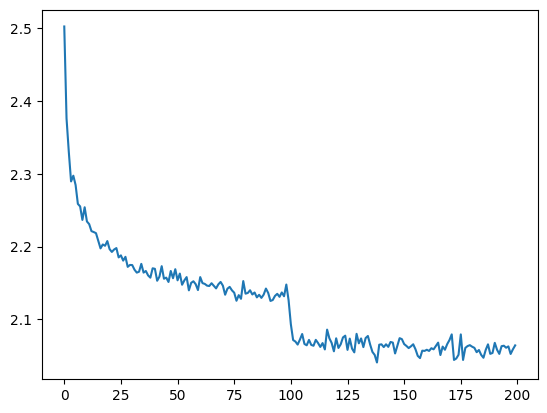

In [20]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [21]:
# eval loss
@torch.no_grad()
def split_loss(split):
	x,y = {
		'train': (train_x, train_y),
		'val': (val_x, val_y),
		'test': (test_x, test_y),
	}[split]
	embed = C[x]
	x = embed.view(embed.shape[0], -1)
	for layer in layers:
		x = layer(x)
	loss = F.cross_entropy(x, y)
	print(split, loss.item())
 
split_loss('train')
split_loss('val')

train 3.2949862480163574
val 3.2947444915771484


In [22]:
for _ in range(20):
	
	out = []
	context = [0] * block_size
	while True:
		embed = C[torch.tensor([context])]
		x = embed.view(embed.shape[0], -1)
		print(x)
		for layer in layers:
			x = layer(x)
		logits = x
		probs = F.softmax(logits, dim=1)
		ix = torch.multinomial(probs, num_samples=1).item()
  
  
		out.append(ix)
		context = context[1:] + [ix]
		if ix == 0:
			break
	print(itos[i] for i in out)


tensor([[ 0.7469,  0.9289,  0.3156, -0.4237,  0.4632, -0.1888,  0.4812, -1.0846,
         -0.3489,  0.7696,  0.7469,  0.9289,  0.3156, -0.4237,  0.4632, -0.1888,
          0.4812, -1.0846, -0.3489,  0.7696,  0.7469,  0.9289,  0.3156, -0.4237,
          0.4632, -0.1888,  0.4812, -1.0846, -0.3489,  0.7696]],
       grad_fn=<ViewBackward0>)


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0